In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(12,7)})

#### Here, we are using Online Retail Data containing transactions from 01/12/2010 and 09/12/2011
http://archive.ics.uci.edu/ml/datasets/online+retail

In [2]:
Rtl_data = pd.read_csv("../input/retail/Online Retail.csv", encoding = 'unicode_escape',index_col=False)
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
Rtl_data.shape

(541909, 8)

#### Customer Distribution by country

In [4]:
country_cust_data=Rtl_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


As we can see in above table that the customers are distributed differently in different contries. So, for better Visualization purpose we can perform analysis separately for each country.
**Now, we will Keep only United Kingdom data for further analysis.**

In [5]:
Rtl_data = Rtl_data.query("Country=='United Kingdom'").reset_index(drop=True)

#### Data Cleaning Steps:

In [6]:
#missing values in the dataset
Rtl_data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [7]:
#Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

In [8]:
#Validate if there are any negative values in Quantity column
Rtl_data.Quantity.min()

-80995

In [9]:
#Validate if there are any negative values in UnitPrice column
Rtl_data.UnitPrice.min()

0.0

In [10]:
#Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [11]:
#Convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [12]:
Rtl_data.shape

(354345, 8)

#### Feature Extraction Steps:

In [13]:
#Adding new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity'] * Rtl_data['UnitPrice']

In [14]:
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


#  **RFM Modelling**


* Recency(R) = Latest Date - Last Inovice Data 
* Frequency(F) = count of invoice no. of transaction(s)
* Monetary(M) = Sum of Total Amount for each customer

Note: The lower value of R is better. And the higher values of F & M are better. 

In [15]:
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

#Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,22,103,4196.01
2,12748.0,4,4596,33719.73
3,12749.0,22,199,4090.88
4,12820.0,44,59,942.34


In [16]:
RFMScores['Avg'] = RFMScores['Monetary'] // RFMScores['Frequency']

> #####  Recency Descriptive Statistics 

In [17]:
RFMScores.Avg.describe()

count     3921.000000
mean        71.238460
std       1543.783582
min          0.000000
25%         11.000000
50%         17.000000
75%         24.000000
max      77183.000000
Name: Avg, dtype: float64

Text(0.5, 1.0, 'Recency Distribution Curve')

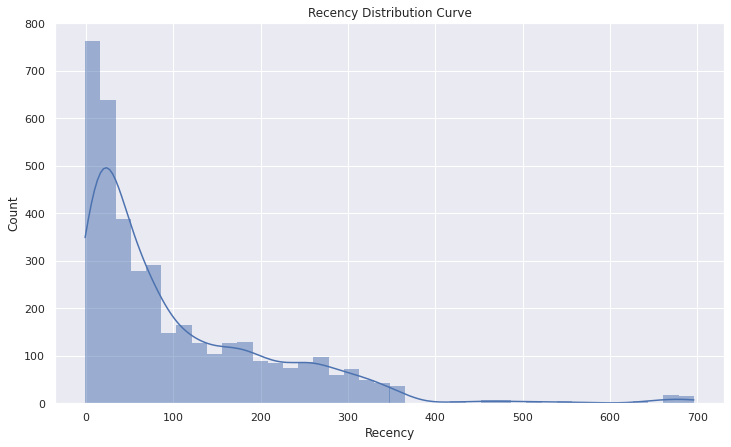

In [18]:
x = RFMScores['Recency']
sns.histplot(x, label="100% Equities", kde=True, linewidth=0)
plt.title("Recency Distribution Curve")

> #####  Frequency Descriptive Statistics 

Text(0.5, 1.0, 'Avg Distribution Curve')

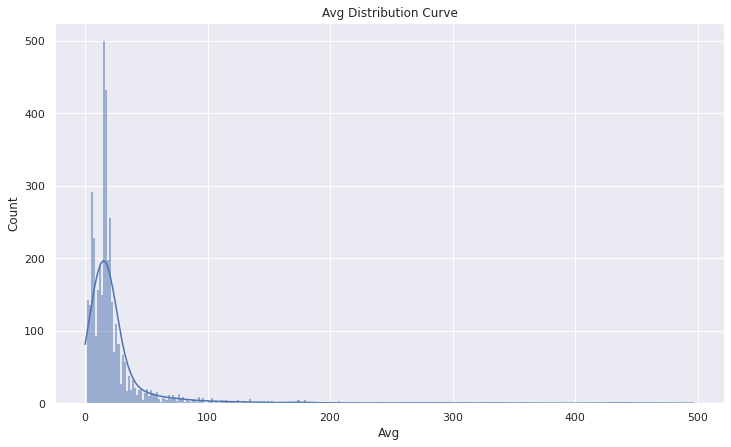

In [19]:
x = RFMScores.query('Avg<500.0')['Avg']
sns.histplot(x, label="100% Equities", kde=True, linewidth=0)
plt.title("Avg Distribution Curve")

> #####  Monetary Descriptive Statistics 

Now, we will create **segments for R and A** using quantile values.

In [20]:
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles 

{'Recency': {0.25: 21.0, 0.5: 60.0, 0.75: 161.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89},
 'Avg': {0.25: 11.0, 0.5: 17.0, 0.75: 24.0}}

In [21]:
#Function to create R segments, where '1' represents lower values of R
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [22]:
#Function to create F and M segments, where '1' represents higher values of both F and M
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [23]:
#Calculate and Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['A'] = RFMScores['Avg'].apply(FnMScoring, args=('Avg',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,Avg,R,A
CustomerID,,,,,,
12346.0,325,1,77183.60,77183.0,4,1
12747.0,22,103,4196.01,40.0,2,1
12748.0,4,4596,33719.73,7.0,1,4
12749.0,22,199,4090.88,20.0,2,2
12820.0,44,59,942.34,15.0,2,3


In [24]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.A.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'A']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,Avg,R,A,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,77183.0,4,1,41,5
12747.0,22,103,4196.01,40.0,2,1,21,3
12748.0,4,4596,33719.73,7.0,1,4,14,5
12749.0,22,199,4090.88,20.0,2,2,22,4
12820.0,44,59,942.34,15.0,2,3,23,5


Note: In Above Table, the **lower values** of RFMScore represents the **most loyal customers**.

In [25]:
#Assigning Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values

#Here qcut is used for dividing data in equal size beans.
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,Avg,R,A,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,77183.0,4,1,41,5,Gold
1,12747.0,22,103,4196.01,40.0,2,1,21,3,Platinum
2,12748.0,4,4596,33719.73,7.0,1,4,14,5,Gold
3,12749.0,22,199,4090.88,20.0,2,2,22,4,Platinum
4,12820.0,44,59,942.34,15.0,2,3,23,5,Gold


In [26]:
#Validating the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='11'].sort_values('Avg', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,Avg,R,A,RFMGroup,RFMScore,RFM_Loyalty_Level
0,16532.0,17,4,6748.80,1687.0,1,1,11,2,Platinum
1,17949.0,2,70,58510.48,835.0,1,1,11,2,Platinum
2,18080.0,18,2,1231.50,615.0,1,1,11,2,Platinum
3,18102.0,11,431,259657.30,602.0,1,1,11,2,Platinum
4,17450.0,2,337,194550.79,577.0,1,1,11,2,Platinum
5,12931.0,21,82,42055.96,512.0,1,1,11,2,Platinum
6,17857.0,17,54,26879.04,497.0,1,1,11,2,Platinum
7,12980.0,8,20,7374.90,368.0,1,1,11,2,Platinum
8,14424.0,17,1,322.08,322.0,1,1,11,2,Platinum
9,16013.0,1,139,37130.60,267.0,1,1,11,2,Platinum


In [27]:
! pip3 install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 495.1 kB/s eta 0:00:00


In [28]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj
po.init_notebook_mode(connected=True)

In [29]:
#Recency Vs Frequency
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Avg'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Avg'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Avg'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Avg'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Avg"},
        xaxis= {'title': "Recency"},
        title='Recency Vs Avg : Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


In [30]:
RFMScores

,Recency,Frequency,Monetary,Avg,R,A,RFMGroup,RFMScore,RFM_Loyalty_Level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,77183.0,4,1,41,5,Gold
12747.0,22,103,4196.01,40.0,2,1,21,3,Platinum
12748.0,4,4596,33719.73,7.0,1,4,14,5,Gold
12749.0,22,199,4090.88,20.0,2,2,22,4,Platinum
12820.0,44,59,942.34,15.0,2,3,23,5,Gold
...,...,...,...,...,...,...,...,...,...
18280.0,159,10,180.60,18.0,3,2,32,5,Gold
18281.0,3,7,80.82,11.0,1,4,14,5,Gold
18282.0,215,12,178.05,14.0,4,3,43,7,Bronze


# **K-Means Clustering Model**

#### Feature Scaling Steps:

In [31]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
    
#Applying function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Avg'] = [handle_neg_n_zero(x) for x in RFMScores.Avg]
RFMScores

,Recency,Frequency,Monetary,Avg,R,A,RFMGroup,RFMScore,RFM_Loyalty_Level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,77183.0,4,1,41,5,Gold
12747.0,22,103,4196.01,40.0,2,1,21,3,Platinum
12748.0,4,4596,33719.73,7.0,1,4,14,5,Gold
12749.0,22,199,4090.88,20.0,2,2,22,4,Platinum
12820.0,44,59,942.34,15.0,2,3,23,5,Gold
...,...,...,...,...,...,...,...,...,...
18280.0,159,10,180.60,18.0,3,2,32,5,Gold
18281.0,3,7,80.82,11.0,1,4,14,5,Gold
18282.0,215,12,178.05,14.0,4,3,43,7,Bronze


> **Data Log Transformation**

In [32]:
#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Avg']].apply(np.log, axis = 1).round(3)
Log_Tfd_Data

,Recency,Avg
CustomerID,,
12346.0,5.784,11.254
12747.0,3.091,3.689
12748.0,1.386,1.946
12749.0,3.091,2.996
12820.0,3.784,2.708
...,...,...
18280.0,5.069,2.890
18281.0,1.099,2.398
18282.0,5.371,2.639


Text(0.5, 1.0, 'Recency Distribution after Data normalization')

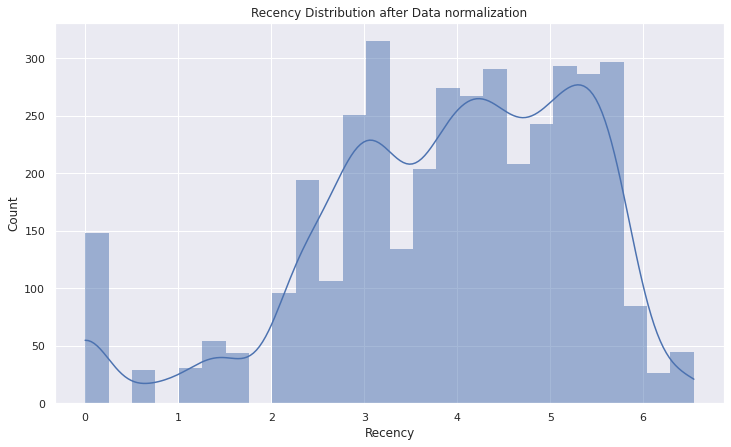

In [33]:
Recency_Plot_data = Log_Tfd_Data['Recency']
sns.histplot(Recency_Plot_data, label="100% Equities", kde=True, linewidth=0)
plt.title("Recency Distribution after Data normalization")

Text(0.5, 1.0, 'Frequency Distribution after Data normalization')

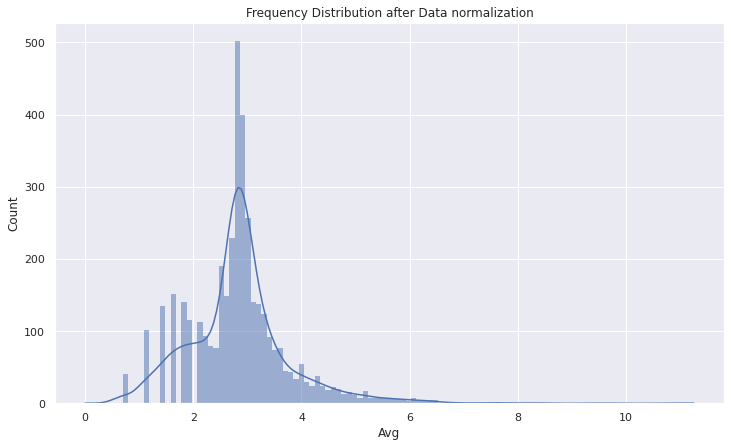

In [34]:
Frequency_Plot_data = Log_Tfd_Data.query('Avg < 500.0')['Avg']
sns.histplot(Frequency_Plot_data, label="100% Equities", kde=True, linewidth=0)
plt.title("Frequency Distribution after Data normalization")

> **Data Standardization**

In [35]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)
Scaled_Data.describe()

,Recency,Avg
count,3.921000e+03,3.921000e+03
mean,2.487171e-16,1.703418e-16
std,1.000128e+00,1.000128e+00
min,-2.739925e+00,-2.980017e+00
25%,-6.117658e-01,-4.623428e-01
50%,1.213833e-01,-5.633771e-03
75%,8.112003e-01,3.565837e-01
max,1.834394e+00,8.835622e+00


In [36]:
Scaled_Data

,Recency,Avg
CustomerID,,
12346.0,1.302529,8.835622
12747.0,-0.579616,0.893086
12748.0,-1.771246,-0.936900
12749.0,-0.579616,0.165501
12820.0,-0.095277,-0.136872
...,...,...
18280.0,0.802814,0.054211
18281.0,-1.971831,-0.462343
18282.0,1.013882,-0.209315


Finding Optimal number of clusters (**K's value**) using **Elbow Method**

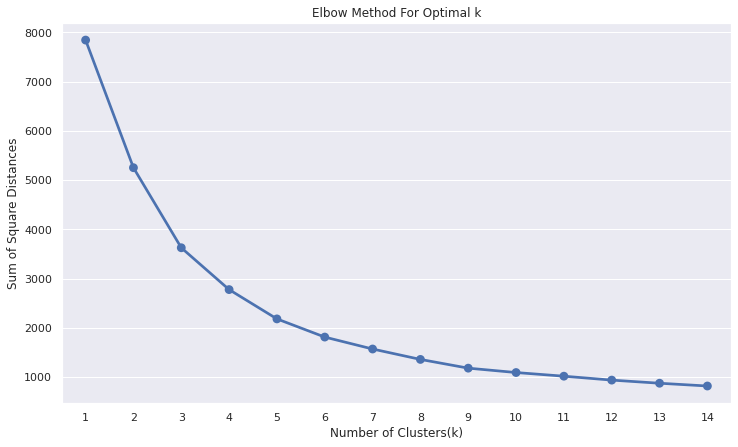

In [37]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
#Building the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,Avg,R,A,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,77183.0,4,1,41,5,Gold,2
12747.0,22,103,4196.01,40.0,2,1,21,3,Platinum,2
12748.0,4,4596,33719.73,7.0,1,4,14,5,Gold,0
12749.0,22,199,4090.88,20.0,2,2,22,4,Platinum,0
12820.0,44,59,942.34,15.0,2,3,23,5,Gold,1


(0.0, 1000.0)

<Figure size 504x504 with 0 Axes>

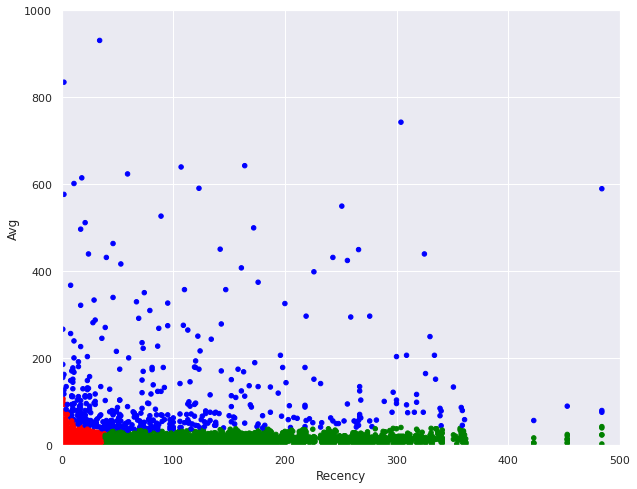

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Avg",
    figsize=(10,8),
    c = RFMScores['Color']
)
plt.xlim(0,500)
plt.ylim(0,1000)

In [40]:
RFMScores

,Recency,Frequency,Monetary,Avg,R,A,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,77183.0,4,1,41,5,Gold,2,blue
12747.0,22,103,4196.01,40.0,2,1,21,3,Platinum,2,blue
12748.0,4,4596,33719.73,7.0,1,4,14,5,Gold,0,red
12749.0,22,199,4090.88,20.0,2,2,22,4,Platinum,0,red
12820.0,44,59,942.34,15.0,2,3,23,5,Gold,1,green
...,...,...,...,...,...,...,...,...,...,...,...
18280.0,159,10,180.60,18.0,3,2,32,5,Gold,1,green
18281.0,3,7,80.82,11.0,1,4,14,5,Gold,0,red
18282.0,215,12,178.05,14.0,4,3,43,7,Bronze,1,green


> #### Now we will see the distribution of different type of customers in each cluster.  

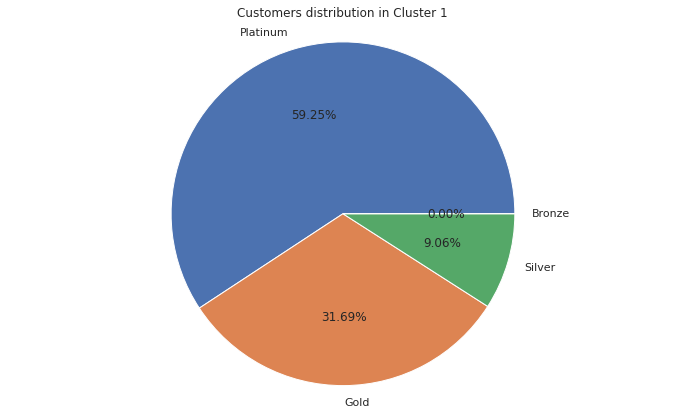

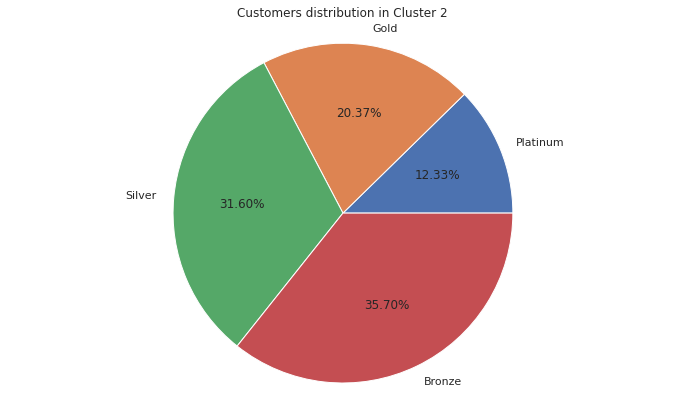

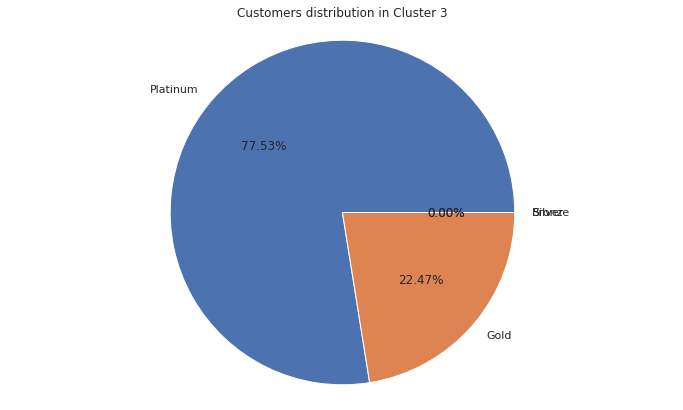

In [41]:
# Separating RFMScores in clusters
clust1 = RFMScores[(RFMScores['Cluster']==0)]
c1=clust1['RFM_Loyalty_Level'].value_counts()
clust2 = RFMScores[(RFMScores['Cluster']==1)]
c2=clust2['RFM_Loyalty_Level'].value_counts()
clust3 = RFMScores[(RFMScores['Cluster']==2)]
c3=clust3['RFM_Loyalty_Level'].value_counts()

def Pie_num(s, x):
    return s[x]

Customer_labels = ['Platinum', 'Gold', 'Silver', 'Bronze']
print("\n")

#For cluster no.1
sizes1=[Pie_num(c1,Customer_labels[i]) for i in range(4)]
fig, ax = plt.subplots()
ax.pie(sizes1, labels=Customer_labels, autopct='%1.2f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Customers distribution in Cluster 1')
plt.show()
print("\n")

#For cluster no.2
sizes2=[Pie_num(c2,Customer_labels[i]) for i in range(4)]
fig, ax = plt.subplots()
ax.pie(sizes2, labels=Customer_labels, autopct='%1.2f%%')
ax.axis('equal')  
ax.set_title('Customers distribution in Cluster 2')
plt.show()
print("\n")

#For cluster no.3 
sizes3=[Pie_num(c3,Customer_labels[i]) for i in range(4)]
fig, ax = plt.subplots()
ax.pie(sizes3, labels=Customer_labels, autopct='%1.2f%%')
ax.axis('equal')
ax.set_title('Customers distribution in Cluster 3')
plt.show()